In [229]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


#### Load a test image

(356, 460)


(-0.5, 459.5, 355.5, -0.5)

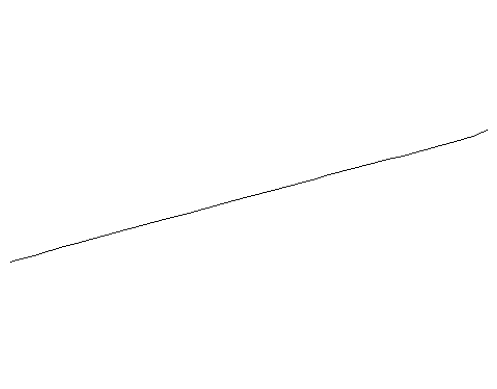

In [230]:
# load a test image and convert from BGR to RGB, also make a grayscale copy
img = cv2.imread("./slightly_tilted_line.png", cv2.IMREAD_GRAYSCALE)
print(img.shape)
plt.imshow(img, cmap='gray')
plt.axis('off')

#### Apply Canny edge detcion to get an edge map of the image

(-0.5, 459.5, 355.5, -0.5)

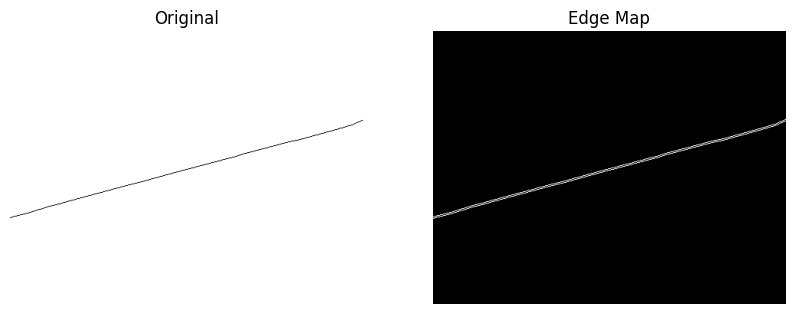

In [232]:
img_edge = cv2.Canny(img, threshold1=100, threshold2=200, apertureSize=3)

plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.imshow(img, cmap='gray')
plt.title('Original')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img_edge, cmap='gray')
plt.title('Edge Map')
plt.axis('off')

In [233]:
print(np.argmax(img_edge[:,0]))
print(img_edge.shape[0] - 1 - np.argmax(img_edge[:,-1]))

242
240


In [234]:
(240-113)/img_edge.shape[1]

0.27608695652173915

#### A basic version of Hough Transform using cartesian parameter representation, i.e. the parameters (a,b) represent the (slope, y-intercept) of the line. The hyperparameters are the number of bins and the thresholding to find the intersection/voting peaks and the number of peaks (i.e. number of lines to detect)

In [235]:
import os

In [286]:
def hough_cart(img, num_lines=20, a_bins=10000, b_bins=10000):

    # specify parameter space bounds, will get split into equal sized bins 
    amin = -500
    amax = 500
    bmin = -10000
    bmax = 10000

    # specify bin parameter values
    a_bin_edges = np.linspace(amin, amax, a_bins+1)
    a_bin_values = 0.5 * (a_bin_edges[0:-1] + a_bin_edges[1:])
    b_bin_edges = np.linspace(bmin, bmax, b_bins+1)
    b_bin_values = 0.5 * (b_bin_edges[0:-1] + b_bin_edges[1:])

    # create a grid of bins in parameter space
    bins = np.zeros(shape=(a_bins, b_bins))

    # iterate over each pixel position
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            # accumulate votes in parameter space bins if the pixel is an edge point
            if(img[y,x]>0):
                # note, the y-cordinate of the image point is flipped
                b_values = (img.shape[0]-1-y) - a_bin_values * x
                b_values_bins = np.digitize(b_values, b_bin_edges)-1

                # clip values that fall outside the bins and place them into the edge bins    
                b_values_bins[b_values_bins<0] = 0
                b_values_bins[b_values_bins>b_bins-1] = b_bins-1
                #print(b_values_bins)
                #print(b_values)
                
                for i in range(a_bins):
                    bins[i,b_values_bins[i]] += 1        


    # set the edge bins to zero to remove large values
    bins[0,:] = 0
    bins[-1,:] = 0
    bins[:,0] = 0
    bins[:,-1] = 0

    # perform thresholding
    thr = 0.2
    bins_thr = np.array(bins)
    bins_thr[bins_thr < thr*np.max(bins)] = 0

    # now find the bins with largest number of vote counts
    #plt.imshow(bins_thr[5000:5100,5500:5600])


    flat_indices = np.argpartition(bins_thr, -num_lines, axis=None)[-num_lines:]

    # Sort the indices based on the corresponding values
    sorted_indices = flat_indices[np.argsort(bins_thr.flat[flat_indices])]

    # Convert the sorted flat indices to row and column indices
    row_indices, col_indices = np.unravel_index(sorted_indices, bins_thr.shape)

    #print(row_indices)
    #print(col_indices)
    
    # peak parameter values
    peaks = []
    for i in range(len(row_indices)):
        peak = (a_bin_values[row_indices[i]], img.shape[0]-1-b_bin_values[col_indices[i]])
        peaks.append(peak)
        print(f"Peak {i}: {peak}, Votes: {bins[row_indices[i], col_indices[i]]}")

    return peaks


[5027 5027 5027 5027 5027 5026 5027 5026 5027 5026 5026 5026 5026 5026
 5027 5026 5026 5027 5026 5027]
[5558 5563 5564 5566 5565 5577 5553 5575 5557 5573 5576 5567 5574 5563
 5554 5565 5564 5555 5566 5556]
Peak 0: (0.27500000000000213, 243.29999999999995), Votes: 43.0
Peak 1: (0.27500000000000213, 242.29999999999995), Votes: 43.0
Peak 2: (0.27500000000000213, 242.10000000000002), Votes: 44.0
Peak 3: (0.27500000000000213, 241.69999999999993), Votes: 45.0
Peak 4: (0.27500000000000213, 241.89999999999998), Votes: 46.0
Peak 5: (0.26500000000000057, 239.4999999999999), Votes: 48.0
Peak 6: (0.27500000000000213, 244.29999999999995), Votes: 49.0
Peak 7: (0.26500000000000057, 239.89999999999998), Votes: 50.0
Peak 8: (0.27500000000000213, 243.4999999999999), Votes: 50.0
Peak 9: (0.26500000000000057, 240.29999999999995), Votes: 53.0
Peak 10: (0.26500000000000057, 239.69999999999993), Votes: 54.0
Peak 11: (0.26500000000000057, 241.4999999999999), Votes: 54.0
Peak 12: (0.26500000000000057, 240.1000

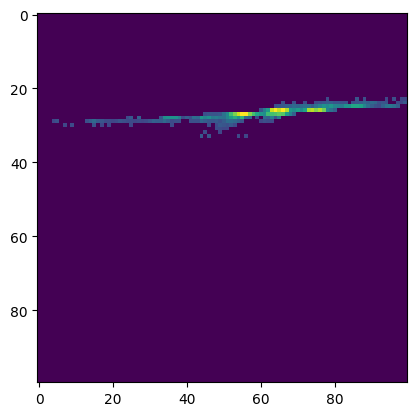

In [241]:
lines = hough_cart(img_edge)

#### Visualizing the lines

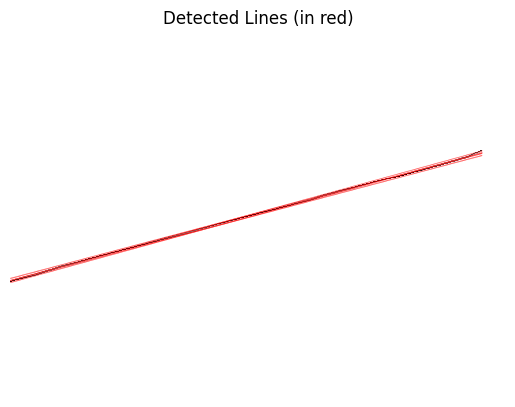

In [265]:
# first convert the gray scale image to color
color_img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) 

plt.imshow(color_img) 
plt.title("Detected Lines (in red)")
plt.axis('off')

# display the lines overlayed on the image
for line in lines:
    a, b = line
    a = -a
    x = np.linspace(0,color_img.shape[1],10)
    y = a*x + b

    # draw the line in red
    plt.plot(x,y, color='red', linestyle='--', linewidth=0.15)



plt.show()

#### Now, lets try a different image

(406, 611)


(-0.5, 610.5, 405.5, -0.5)

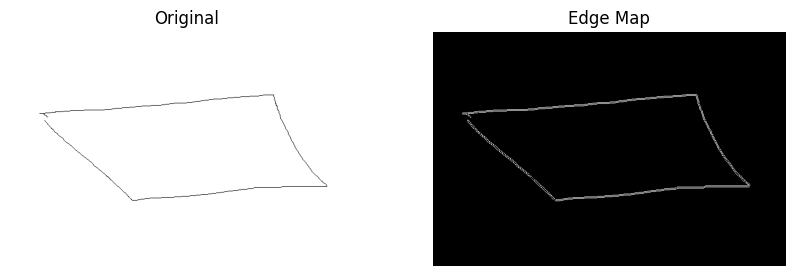

In [268]:
# load a test image and convert from BGR to RGB, also make a grayscale copy
img2 = cv2.imread("./paralellogram.png", cv2.IMREAD_GRAYSCALE)
print(img2.shape)

img_edge2 = cv2.Canny(img2, threshold1=100, threshold2=200, apertureSize=3)

plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.imshow(img2, cmap='gray')
plt.title('Original')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img_edge2, cmap='gray')
plt.title('Edge Map')
plt.axis('off')

In [291]:
lines2 = hough_cart(img_edge2, num_lines=50)

Peak 0: (0.1500000000000341, 324.0), Votes: 46.0
Peak 1: (-0.04999999999998295, 272.0), Votes: 46.0
Peak 2: (0.1500000000000341, 328.0), Votes: 47.0
Peak 3: (0.1500000000000341, 154.0), Votes: 47.0
Peak 4: (-0.9499999999999886, 94.0), Votes: 48.0
Peak 5: (-0.9499999999999886, 90.0), Votes: 49.0
Peak 6: (-1.2499999999999716, -414.0), Votes: 49.0
Peak 7: (-1.6499999999999773, -616.0), Votes: 50.0
Peak 8: (0.1500000000000341, 176.0), Votes: 50.0
Peak 9: (-0.04999999999998295, 248.0), Votes: 50.0
Peak 10: (-0.04999999999998295, 128.0), Votes: 52.0
Peak 11: (-0.9499999999999886, 98.0), Votes: 53.0
Peak 12: (0.1500000000000341, 160.0), Votes: 53.0
Peak 13: (-1.7499999999999716, -666.0), Votes: 54.0
Peak 14: (-0.04999999999998295, 244.0), Votes: 54.0
Peak 15: (-1.349999999999966, -466.0), Votes: 55.0
Peak 16: (-2.049999999999983, -812.0), Votes: 56.0
Peak 17: (0.1500000000000341, 174.0), Votes: 57.0
Peak 18: (-0.7499999999999716, 122.0), Votes: 57.0
Peak 19: (-1.9499999999999886, -764.0), Vot

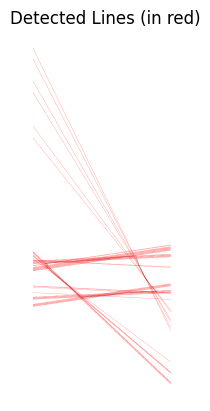

In [292]:
# first convert the gray scale image to color
color_img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2RGB) 

plt.imshow(color_img2) 
plt.title("Detected Lines (in red)")
plt.axis('off')

# display the lines overlayed on the image
for line in lines2:
    a, b = line
    a = -a
    x = np.linspace(0,color_img2.shape[1],10)
    y = a*x + b

    # draw the line in red
    plt.plot(x,y, color='red', linestyle='--', linewidth=0.15)



plt.show()